In [1]:
import os, glob, json

import re, math

import numpy as np
import pandas as pd
import matplotlib 

import matplotlib

# Here ya go, Political Analysis!
matplotlib.rcParams['font.sans-serif'] = ['Verdana', "Arial"]
matplotlib.rcParams['font.family'] = "sans-serif"

from matplotlib.font_manager import findfont, FontProperties
print("Font is now:", findfont(FontProperties(family=['sans-serif'])))

import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import norm
import statsmodels.api as sm
import statsmodels.discrete.discrete_model as sm_dm

from IPython.display import display
pd.options.display.max_columns = 1000

import seaborn as sns
sns.set(rc={"figure.figsize" : (8, 6)})
sns.set(font_scale = 1.0) 
sns.set(style="white", color_codes=True)
sns.set_context('notebook', font_scale=1.0, rc={'line.linewidth': 2.5, "figure.figsize" : (8, 4)})

Font is now: /usr/share/fonts/truetype/msttcorefonts/Verdana.ttf


## Prepare and Cache Data for Replication

This code saves intermediate results to facilitate replication from the repository, without private resources.

In [2]:
REPLICATION = True

try:
    
    if not REPLICATION:
        import requests
        import psycopg2

        from netrc import netrc    
        user, acct, passwd = netrc().authenticators("harris")

except:

    print("Cannot/will not re-recreate intermediate results without DB connection.")

### Load and save the racial/ethnic composition of _actual_ districts, from the Census.

In [3]:
if not REPLICATION:

    # Normal Names
    columns = ["Male VAP", "Female VAP", "Male BVAP", "Female BVAP", "Male HVAP", "Female HVAP", "State", "CD"]

    # Census API Call Format -- variable names are the same in the 3 years.
    api_endpt = "https://api.census.gov/data/{}/acs/acs5?for=congressional+district:*&get=" + \
                "B05003_008E,B05003_019E,B05003B_008E,B05003B_019E,B05003I_008E,B05003I_019E"

    j113 = requests.get(api_endpt.format(2012)).json()
    j114 = requests.get(api_endpt.format(2014)).json()
    j115 = requests.get(api_endpt.format(2016)).json()

    df113 = pd.DataFrame(columns = columns, data = j113[1:]).astype(int)
    df113["Session"] = 113

    df114 = pd.DataFrame(columns = columns, data = j114[1:]).astype(int)
    df114["Session"] = 114

    df115 = pd.DataFrame(columns = columns, data = j115[1:]).astype(int)
    df115["Session"] = 115

    vaps = pd.concat([df113, df114, df115])

    vaps.loc[vaps.CD == 0, "CD"] = 1
    vaps.loc[vaps.CD == 98, "CD"] = 1
    
    # Good-bye DC.
    vaps = vaps[(vaps.State != 11) & (vaps.State < 57)]

    vaps["VAP"]  = vaps["Male VAP"] + vaps["Female VAP"]
    vaps["BVAP"] = vaps["Male BVAP"] + vaps["Female BVAP"]
    vaps["HVAP"] = vaps["Male HVAP"] + vaps["Female HVAP"]

    vaps["black_vap_frac"]          = vaps["BVAP"] / vaps["VAP"]
    vaps["hispanic_vap_frac"]       = vaps["HVAP"] / vaps["VAP"]
    vaps["total_minority_vap_frac"] = vaps["black_vap_frac"] + vaps["hispanic_vap_frac"]
    vaps["max_minority_vap_frac"]   = vaps[["black_vap_frac", "hispanic_vap_frac"]].max(axis = 1)

    vaps = vaps[["State", "CD", "Session",
                 "black_vap_frac", "hispanic_vap_frac", 
                 "total_minority_vap_frac", "max_minority_vap_frac"]]

    # Cache it.
    vaps.to_csv("data/census_api_cd_vaps.csv", index = False)
    

### Load and save the tract race data for the entire country.

In [4]:
if not REPLICATION:

    tract_race = pd.read_sql("""SELECT
                                  s.usps, rn.rn, 
                                  d.state, d.county cid, d.tract,
                                  b01001_001e pop, b01001a_001e white,
                                  b01001b_001e black, b01001i_001e hispanic,
                                  total_vap, black_vap, hispanic_vap
                                FROM census_tracts_2015 AS g
                                JOIN states AS s ON
                                  g.state = s.fips
                                JOIN acssf5y2015 AS d ON
                                  d.state  = g.state  AND
                                  d.county = g.county AND
                                  d.tract  = g.tract
                                JOIN (SELECT state, county, tract,
                                      row_number() over (PARTITION BY state ORDER BY 
                                                         county, tract NULLS LAST) - 1 as rn
                                      FROM census_tracts_2015) rn ON
                                  g.state  = rn.state  AND
                                  g.county = rn.county AND
                                  g.tract  = rn.tract
                                ORDER BY d.state, d.county, d.tract;
                                """,
                                con = cen_con, index_col = ["usps", "rn"])
    
    tract_race.to_csv("data/tract_race.csv")

## Read in the Cached Data

In [5]:
vaps = pd.read_csv("data/census_api_cd_vaps.csv")
true_minority_shares = vaps.loc[(vaps.Session == 114) & ~vaps.State.isin([11, 72])].copy()

tract_race = pd.read_csv("data/tract_race.csv")

simulated_seats = pd.read_csv("data/c4_redux/power_minority_redux.csv",
                              header = None, names = ["usps", "uid", "black_vap_frac", "hispanic_vap_frac"])
state_seats = pd.read_csv("data/states.csv", index_col = "usps").seats.to_dict()
simulated_seats["seats"] = simulated_seats.usps.replace(state_seats).astype(int)

### Process the Single Seat States

I do not simulate single-district states, so they must be added explicitly.

This aggregation/extraction of the single-district state demographics could be done from the VAPS data of 2012, 2014, and 2016 (when the 113th, 114th, and 115th Congresses were elected).  The values are extremely close but not identical: I have used 2015 ACS 5-year data for the bulk of the project.

In [6]:
single_seat_states = ["AK", "DE", "MT", "ND", "SD", "VT", "WY"]

single_seat_states = tract_race[tract_race.usps.isin(single_seat_states)].groupby("usps").sum()

single_seat_states["black_vap_frac"]    = single_seat_states["black_vap"] / single_seat_states["total_vap"]
single_seat_states["hispanic_vap_frac"] = single_seat_states["hispanic_vap"] / single_seat_states["total_vap"]
single_seat_states["total_minority_vap_frac"] = single_seat_states["black_vap_frac"] + single_seat_states["hispanic_vap_frac"]
single_seat_states["max_minority_vap_frac"]   = single_seat_states[["black_vap_frac", "hispanic_vap_frac"]].max(axis = 1)

single_seat_states = single_seat_states.filter(regex = "frac$", axis = 1).reset_index()
single_seat_states["seats"] = 1

# single_simulated

## Minority VAP Share Crossover Plot.

### Assemble the simulated and single-districts and calculate the weight of each map.

In [7]:
simulated = simulated_seats.append(single_seat_states, sort = False)

simulated.reset_index(drop = True, inplace = True)

# Constructed variables -- not used for paper.
simulated["max_minority_vap_frac"] = simulated[["black_vap_frac", "hispanic_vap_frac"]].max(axis = 1)
simulated["total_minority_vap_frac"] = simulated[["black_vap_frac", "hispanic_vap_frac"]].sum(axis = 1)

# How much is each individual seat/plan worth?
nsim = simulated.groupby("usps").count()[["seats"]]
nsim.rename(columns = {"seats" : "simulated"}, inplace = True)
nsim[["seats"]] = simulated.groupby("usps").mean()[["seats"]]
nsim["weight"] = nsim["seats"] / nsim["simulated"]
nsim.reset_index(inplace = True)

# Merge the weights back on.
simulated = simulated[["usps", "seats", "black_vap_frac", "hispanic_vap_frac", 
                       "max_minority_vap_frac", "total_minority_vap_frac"]].merge(nsim[['usps', 'weight']], on = "usps")

### Plotting Function

In [8]:
def plot(xvar, xtitle, f, seats, legend = False):

    true_minority_shares.sort_values(by = xvar, inplace = True)
    true_minority_shares.reset_index(drop = True, inplace = True)
    true_minority_shares["cum_seats"] = list(435 - true_minority_shares.index.array)

    simulated.sort_values(by = xvar, ascending = False, inplace = True)
    simulated.reset_index(drop = True, inplace = True)
    simulated["cum_seats"] = simulated[["weight"]].cumsum()

    ax = simulated.plot(x = xvar, y = "cum_seats", color = "red", linewidth = 2,
                        label = "Power Diagrams", legend = legend)

    true_minority_shares.plot(x = xvar, y = "cum_seats", color = "k", linewidth = 2, linestyle = "dotted",
                              ax = ax, label = "114th Congress")
    
    
    frac = true_minority_shares[true_minority_shares["cum_seats"] <= seats][xvar].min()
    ax.plot([0.1, frac], [seats, seats], linewidth = 0.5, linestyle = "solid", color = "k")
    print(xtitle, "crossing:", frac)

    ax.set_xlabel(xtitle)
    ax.set_xlim(0.15, 0.6)

    ax.set_ylabel("Seats")
    ax.set_yticks([0, 25, 50, 75, 100, 125])
    
    # The plot y limits stretch between "corners" of the simulated seats.
    mini = simulated[simulated[xvar] < 0.60]["cum_seats"].min()
    maxi = simulated[simulated[xvar] > 0.15]["cum_seats"].max()
    ax.set_ylim(0, 110)

    sns.despine()
    
    plt.legend(loc='upper right')
    ax.legend().set_visible(legend)

    ax.get_figure().savefig(f, bbox_inches='tight', pad_inches=0.3)
    

### Make the plots for Blacks and Hispanics, both VAP.

Black Share (VAP) crossing: 0.301071319363903
Hispanic Share (VAP) crossing: 0.4104245847652565


/home/jsaxon/anaconda3/envs/pa_rep/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/jsaxon/anaconda3/envs/pa_rep/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/jsaxon/anaconda3/envs/pa_rep/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


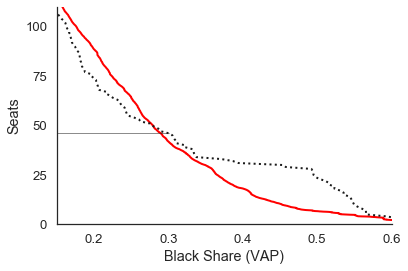

/home/jsaxon/anaconda3/envs/pa_rep/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


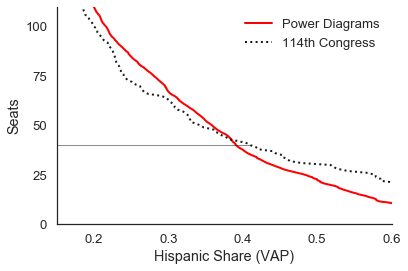

In [9]:
sns.set_context('notebook', font_scale=1.2, rc={'line.linewidth': 2.5, "figure.figsize" : (4, 2.5)})

plot("black_vap_frac",    "Black Share (VAP)",    "paper_figs/black_vap_representation.pdf", 46)
plot("hispanic_vap_frac", "Hispanic Share (VAP)", "paper_figs/hispanic_vap_representation.pdf", 40, True)

## The Probit Model

### Load the actual outcomes.

Note that I am rejecting here the delegates -- from DC, VI, MP, and PR -- all of whom are minorities.

In [10]:
! cat min_rep/sources.txt

http://history.house.gov/Exhibitions-and-Publications/BAIC/Historical-Data/Black-American-Representatives-and-Senators-by-Congress/
http://history.house.gov/Exhibitions-and-Publications/HAIC/Historical-Data/Hispanic-American-Representatives,-Senators,-Delegates,-and-Resident-Commissioners-by-Congress/

https://pressgallery.house.gov/member-data/demographics/african-americans
https://pressgallery.house.gov/member-data/demographics/hispanic-americans

Discrepancies (in pressgallery but not history -- added):
Trent Franks R-AZ-8
John Garamendi D-CA-3
Brian Mast R-FL-18

https://api.census.gov/data/2012/acs5?for=congressional+district:*&get=NAME,B05003_008E,B05003_019E,B05003B_008E,B05003B_019E,B05003I_008E,B05003I_019E
https://api.census.gov/data/2014/acs5?for=congressional+district:*&get=NAME,B05003_008E,B05003_019E,B05003B_008E,B05003B_019E,B05003I_008E,B05003I_019E

See also: http://www.pewresearch.org/fact-tank/2017/01/24/115th-congress-sets-new-high-for-racial-ethnic-diversity/



#### Swap USPS for FIPS, make sure we've dropped delegates.

In [11]:
min_rep = pd.read_excel("min_rep/minority_representatives.xlsx")

# st = pd.read_sql("select usps, fips from states;", con = cen_con)
st = pd.read_csv("data/states.csv", usecols = ["usps", "fips"])

min_rep = pd.merge(min_rep, st, left_on = "State", right_on = "usps")
min_rep = min_rep[(min_rep.Delegate == 0) & ((min_rep.Session == 113) | (min_rep.Session == 114) | (min_rep.Session == 115))]
min_rep = min_rep[["Session", "fips", "CD", "Ethnicity", "Name", "Delegate"]].rename(columns = {"fips" : "State"})
min_rep.sort_values(by = ["Session", "State", "CD"], inplace = True)
min_rep.reset_index(drop = True, inplace = True)

# min_rep

#### Exog.

In [12]:
min_rep_merge = vaps.merge(min_rep, on = ["Session", "State", "CD"], how = "outer")
min_rep_merge["BRep"] = (min_rep_merge["Ethnicity"] == "B").astype(int)
min_rep_merge["HRep"] = (min_rep_merge["Ethnicity"] == "H").astype(int)
min_rep_merge["MRep"] = (~min_rep_merge["Ethnicity"].isnull()).astype(int)
min_rep_merge["const"] = 1
min_rep_merge.sort_values(by = ["State", "CD", "Session"], inplace = True)

#### Keeping only one of Chaka Fattah or Dwight Evans, and Xavier Becerra or Jimmy Gomez, since they were all elected from the same districts.

In [13]:
min_rep_merge.drop_duplicates(["Session", "State", "CD"], inplace = True, keep = "first")
min_rep_merge[(min_rep_merge.MRep == 1) & (min_rep_merge.duplicated(["State", "CD", "Session"], keep = False))].sort_values(by = ["Session", "State", "CD"])

,State,CD,Session,black_vap_frac,hispanic_vap_frac,total_minority_vap_frac,max_minority_vap_frac,Ethnicity,Name,Delegate,BRep,HRep,MRep,const


In [14]:
min_rep_merge.to_csv("data/min_rep.csv")

In [15]:
min_rep_merge.groupby("Session")[["BRep", "HRep"]].sum()

,BRep,HRep
Session,,
113,41,33
114,44,34
115,46,40


### Probit model function: run probit and sum probabilities over seats.

In [16]:
def run_probit(session, frac, truth, sim_var, label, ax):
    
    session_slice = min_rep_merge[min_rep_merge.Session == session].copy(deep = True)
    session_slice.reset_index(drop = True, inplace = True)

    probit = sm_dm.Probit(session_slice[truth], session_slice[[frac, "const"]]).fit(disp = False)
    
    session_slice["Probit"] = norm.sf(- (session_slice[frac] * probit.params[frac] + probit.params.const))

    if not ax: fig, ax = plt.subplots(figsize = (2, 2))
    session_slice.sort_values(by = frac).plot(x = frac, y = truth,    # label = "Representatives", 
                                              c = 'b', kind = "scatter", ax = ax)
    session_slice.sort_values(by = frac).plot(x = frac, y = "Probit", # label = "Probit Model", 
                                              c = 'r', kind = "scatter", ax = ax)

    ax.set_ylabel("Minority Rep.")
    ax.set_xlabel(label + " Fraction")

    probit_seats = session_slice.drop_duplicates(["State", "CD"]).Probit.sum()
    simulated_seats = (simulated["weight"] * norm.sf(- (simulated[sim_var] * probit.params[frac] + probit.params.const))).sum()

    print("{:17s} 0.50 at {:.3f}  probit_seats={:.1f} sim_seats={:.1f}  ratio={:.3f}"\
          .format(sim_var, - probit.params.const / probit.params[frac], 
                  probit_seats, simulated_seats, simulated_seats / probit_seats))
    

black_vap_frac    0.50 at 0.352  probit_seats=46.0 sim_seats=42.1  ratio=0.916
hispanic_vap_frac 0.50 at 0.520  probit_seats=40.0 sim_seats=37.0  ratio=0.927


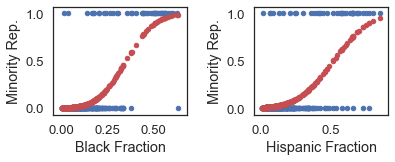

In [17]:
fig, ax = plt.subplots(1, 2, figsize = (6, 2))

run_probit(115, "black_vap_frac",    "BRep", "black_vap_frac",    "Black",    ax[0])
run_probit(115, "hispanic_vap_frac", "HRep", "hispanic_vap_frac", "Hispanic", ax[1])

plt.subplots_adjust(wspace = 0.5)

In [18]:
min_rep_merge[(min_rep_merge.Session == 115) & (min_rep_merge.black_vap_frac >=  0.2)].shape[0], \
min_rep_merge[(min_rep_merge.Session == 115) & (min_rep_merge.black_vap_frac >=  0.3)].shape[0]

(74, 45)